In [1]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
import seaborn as sns
from sklearn.metrics import accuracy_score

C:\Users\kapgo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Набор данных

C:\Users\kapgo\AppData\Local\Temp\ipykernel_2004\2396225507.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(replacement_map, inplace=True)


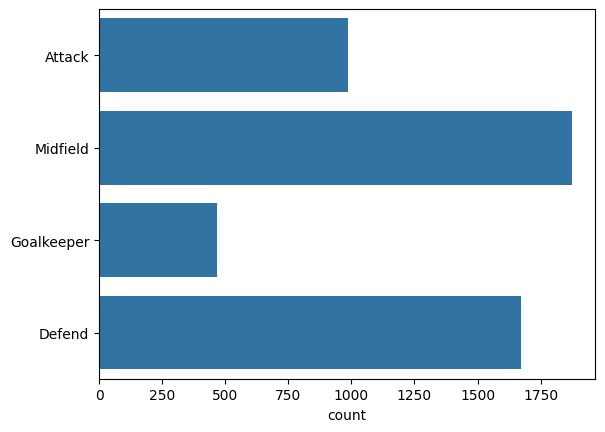

In [2]:
df = pd.read_csv('male_players.csv')
df = df.head(5000)
df.drop(columns=['n','Name', 'URL', 'GK', 'Gender', 'Club', 'Nation'], inplace=True)
df = pd.get_dummies(df, columns=['Preferred foot'])
replacement_map = {'Low': 0, 'Medium': 0.5, 'High': 1}
df.replace(replacement_map, inplace=True)
numerical_cols = df.select_dtypes(include=['int', 'float']).columns
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df.dropna(inplace=True)
position_mapping = {
    'CAM': 'Midfield',
    'CB': 'Defend',
    'CDM': 'Midfield',
    'CF': 'Attack',
    'CM': 'Midfield',
    'GK': 'Goalkeeper',
    'LB': 'Defend',
    'LM': 'Midfield',
    'LW': 'Attack',
    'LWB': 'Defend',
    'RB': 'Defend',
    'RM': 'Midfield',
    'RW': 'Attack',
    'RWB': 'Defend',
    'ST': 'Attack'
}
df['Position'] = df['Position'].replace(position_mapping)

X = df.drop('Position', axis=1).to_numpy()
target = df['Position'].to_numpy()

sns.countplot(target)
plt.show()

In [3]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)


In [4]:
np.unique(target)

array(['Attack', 'Defend', 'Goalkeeper', 'Midfield'], dtype=object)

# Расстояние Минковского

$$D = \left( \sum_{i=1}^{n} |x_{i}^{(A)} - x_{i}^{(B)}|^p \right)^{\frac{1}{p}}$$


In [5]:
def minkowski_distance(x1: np.array, x2: np.array, p=2):
    return np.power(np.sum(np.abs(x1 - x2) ** p), 1/p)

# Косинусное расстояние

$$
D = 1 - \frac{A \cdot B}{\|A\| \|B\|}
$$


In [6]:
def cosine_distance(x1, x2):
    dot_product = np.dot(x1, x2)
    norm_x1 = np.linalg.norm(x1)
    norm_x2 = np.linalg.norm(x2)
    cosine_similarity = dot_product / (norm_x1 * norm_x2)
    cosine_distance = 1 - cosine_similarity
    return cosine_distance

# Расстояние Чебышева

$$
ρ(a, b) = max_i |a_i - b_i|

$$

In [7]:
def chebyshev_distance(x, y):
    return np.max(np.abs(x - y))   

# Равномерное ядро

$$
Uniform(u) = \frac{1}{2} \cdot [u \lt 1]
$$

In [8]:
def uniform_kernel(u):
    return 0.5 * np.where(np.abs(u) < 1, 1, 0)

# Треугольное ядро

$$
Triangular(u) = (1 - |u|) \cdot [u \lt 1]
$$

In [9]:
def triangular_kernel(u):
    return np.maximum(1 - np.abs(u), 0)

# Ядро Епанечникова

$$
 Epanechnikov(u) = \frac{3}{4} \cdot (1 - u^2) \cdot [u \lt 1]
$$

In [10]:
def epanechnikov_kernel(u):
    return 3/4*(1-u**2)*np.where(np.abs(u) < 1, 1, 0)

# Гауссово ядро

$$
Gaussian(u) = \frac{1}{\sqrt{2\pi}} \cdot exp(\frac{-u^2}{2})
$$

In [11]:
def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u ** 2)

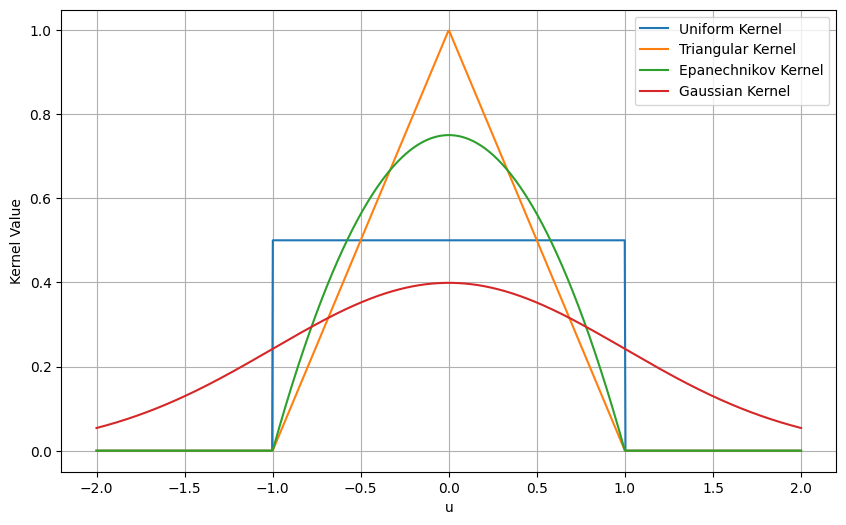

In [12]:
u_values = np.linspace(-2, 2, 1000)

uniform_kernel_values = uniform_kernel(u_values)
triangular_kernel_values = triangular_kernel(u_values)
gaussian_kernel_values = gaussian_kernel(u_values)
epanechnikov_kernel_values = epanechnikov_kernel(u_values)

plt.figure(figsize=(10, 6))
plt.plot(u_values, uniform_kernel_values, label='Uniform Kernel')
plt.plot(u_values, triangular_kernel_values, label='Triangular Kernel')
plt.plot(u_values, epanechnikov_kernel_values, label='Epanechnikov Kernel')
plt.plot(u_values, gaussian_kernel_values, label='Gaussian Kernel')

plt.xlabel('u')
plt.ylabel('Kernel Value')
plt.legend()
plt.grid(True)
plt.show()


# Алгоритм

$$
a(u; D_{\text{train}}) = \arg \max_{y \in Y} \sum_{i=1}^{|D_{\text{train}}|} \left[ y(x_{(u,i)}) = y \right] w_{(i, u)}
$$


# Окно Парзена-Розенблатта с фиксированной шириной окна

$$
a(u; D_{\text{train}}; h; K) = \arg \max_{y \in Y} \sum_{i=1}^{|D_{\text{train}}|} \left[ y(x_{(u,i)}) = y \right] K\left( \frac{\rho(u, x_{(u,i)})}{h} \right)
$$

In [13]:
def fixed_window(u, x, y, h, metric, kernel, aprior_weights):
    classes = np.unique(y)
    classes_count = {c: 0 for c in classes}

    if aprior_weights is None:
        aprior_weights = np.ones(len(x))
    for i in range(len(x)):
        weight = kernel(metric(u, x[i]) / h) * aprior_weights[i]
        classes_count[y[i]] += weight
    return max(classes_count, key=classes_count.get)

# Окно Парзена-Розенблатта с нефиксированной шириной окна

$$
a(u; D_{\text{train}}; k; K) = \arg \max_{y \in Y} \sum_{i=1}^{|D_{\text{train}}|} \left[ y(x_{(u,i)}) = y \right] K\left( \frac{\rho(u, x_{(u,i)})}{\rho(u, x_{(u, k+1)})} \right)
$$


In [14]:
def not_fixed_window(u, x, y, n_neighbors, metric, kernel, aprior_weights):
    classes = np.unique(y)
    classes_count = {c: 0 for c in classes}
    distances = []
    for n in x:
        distances.append(metric(u, n))
    distances.sort()    
    if aprior_weights is None:
        aprior_weights = np.ones(len(x))
    for i in range(len(x)):
        weight = kernel(metric(u, x[i]) / distances[n_neighbors + 1]) * aprior_weights[i]
        classes_count[y[i]] += weight
    return max(classes_count, key=classes_count.get)

In [15]:
def knn_classifier(u, 
                   x, 
                   y, 
                   window="fixed",
                   n_neighbors=5,
                   h=0.1,
                   metric="minkowski_distance",
                   kernel="gaussian_kernel",
                   aprior_weights=None,
                   p=2.0):
    metric_map = {'minkowski_distance'   : lambda x, y: minkowski_distance(x, y, p),
                  'cosine_distance'      : cosine_distance,
                  'chebyshev_distance'   : chebyshev_distance}
    metric = metric_map[metric]
    kernel_map = {'uniform_kernel'      : uniform_kernel,
                  'triangular_kernel'   : triangular_kernel,
                  'epanechnikov_kernel' : epanechnikov_kernel,
                  'gaussian_kernel'     : gaussian_kernel}
    kernel = kernel_map[kernel]
    if window == "fixed":
        return fixed_window(u, x, y, h, metric, kernel, aprior_weights)
    else:
        return not_fixed_window(u, x, y, n_neighbors, metric, kernel, aprior_weights)

# Подбор гиперпараметров

In [16]:
def objective(trial):
    window = trial.suggest_categorical('window', ['fixed', 'not_fixed'])
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    h = trial.suggest_float('h', 0.0001, 1)
    metric = trial.suggest_categorical('metric', ['minkowski_distance', 'cosine_distance'])
    kernel = trial.suggest_categorical('kernel', ['uniform_kernel', 'triangular_kernel', 'epanechnikov_kernel', 'gaussian_kernel'])
    p = trial.suggest_float('p', 0.1, 5.0)
    y_pred = []
    for u in X_valid:
        y_pred.append(knn_classifier(u, X_train, y_train, window, n_neighbors, h, metric, kernel, None, p))
    return accuracy_score(y_pred, y_valid)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print('Best params: ', study.best_params)
print('Best accuracy: ', study.best_value)

[I 2024-04-02 23:03:56,305] A new study created in memory with name: no-name-8b34b70b-8b35-4323-a566-3102f3a9e6c2
[I 2024-04-02 23:04:52,599] Trial 0 finished with value: 0.36875 and parameters: {'window': 'fixed', 'n_neighbors': 26, 'h': 0.8898456022495183, 'metric': 'cosine_distance', 'kernel': 'uniform_kernel', 'p': 2.429322162396801}. Best is trial 0 with value: 0.36875.
[I 2024-04-02 23:06:34,416] Trial 1 finished with value: 0.705 and parameters: {'window': 'not_fixed', 'n_neighbors': 24, 'h': 0.11030960489067032, 'metric': 'minkowski_distance', 'kernel': 'gaussian_kernel', 'p': 4.882497232791903}. Best is trial 1 with value: 0.705.
[I 2024-04-02 23:07:54,141] Trial 2 finished with value: 0.86 and parameters: {'window': 'not_fixed', 'n_neighbors': 19, 'h': 0.07548753752648893, 'metric': 'cosine_distance', 'kernel': 'triangular_kernel', 'p': 3.2878832504924147}. Best is trial 2 with value: 0.86.
[I 2024-04-02 23:09:15,864] Trial 3 finished with value: 0.85 and parameters: {'window

Best params:  {'window': 'not_fixed', 'n_neighbors': 19, 'h': 0.18494389000144248, 'metric': 'cosine_distance', 'kernel': 'uniform_kernel', 'p': 4.08570582493875}
Best accuracy:  0.87


In [17]:
def objective(trial):
    n_neighbors = trial.suggest_int("k", 1, 40)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    algorithm = trial.suggest_categorical("algorythm", ["ball_tree", "kd_tree", "brute"])
    p = trial.suggest_float("p", 1, 5)
    y_pred = KNeighborsClassifier(n_neighbors, weights=weights, algorithm=algorithm, p=p).fit(X_train, y_train).predict(X_valid)
    return accuracy_score(y_valid, y_pred)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print('Best params: ', study.best_params)
print('Best accuracy: ', study.best_value)

[I 2024-04-03 01:27:33,132] A new study created in memory with name: no-name-e097c5e3-ca57-4ce7-b5db-13d4febb8434
[I 2024-04-03 01:27:34,762] Trial 0 finished with value: 0.84375 and parameters: {'k': 7, 'weights': 'uniform', 'algorythm': 'kd_tree', 'p': 4.255712365221184}. Best is trial 0 with value: 0.84375.
[I 2024-04-03 01:27:36,190] Trial 1 finished with value: 0.84875 and parameters: {'k': 16, 'weights': 'uniform', 'algorythm': 'brute', 'p': 2.7320907598112245}. Best is trial 1 with value: 0.84875.
[I 2024-04-03 01:27:38,291] Trial 2 finished with value: 0.85125 and parameters: {'k': 28, 'weights': 'uniform', 'algorythm': 'kd_tree', 'p': 3.3008085215216574}. Best is trial 2 with value: 0.85125.
[I 2024-04-03 01:27:39,433] Trial 3 finished with value: 0.84875 and parameters: {'k': 35, 'weights': 'distance', 'algorythm': 'brute', 'p': 4.517642367004383}. Best is trial 2 with value: 0.85125.
[I 2024-04-03 01:27:40,969] Trial 4 finished with value: 0.84625 and parameters: {'k': 7, 'w

Best params:  {'k': 24, 'weights': 'uniform', 'algorythm': 'brute', 'p': 1.035719123436941}
Best accuracy:  0.87875


# Cравнение алгоритмов

In [20]:
my_accuracies_test = []
for k in range(1, 50):
    y_pred = []
    for u in X_test:
        y_pred.append(knn_classifier(u=u, x=X_train, y=y_train, window="not_fixed", n_neighbors=k, metric='cosine_distance', kernel='uniform_kernel', p=4.08570582493875))
    print(k)    
    my_accuracies_test.append(accuracy_score(y_pred, y_test))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [21]:
lib_accuracies_test = []
for k in range(1, 50):
    y_pred = []
    y_pred = KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='brute', p=1.035719123436941).fit(X_train, y_train).predict(X_test)
    print(k)    
    lib_accuracies_test.append(accuracy_score(y_pred, y_test))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


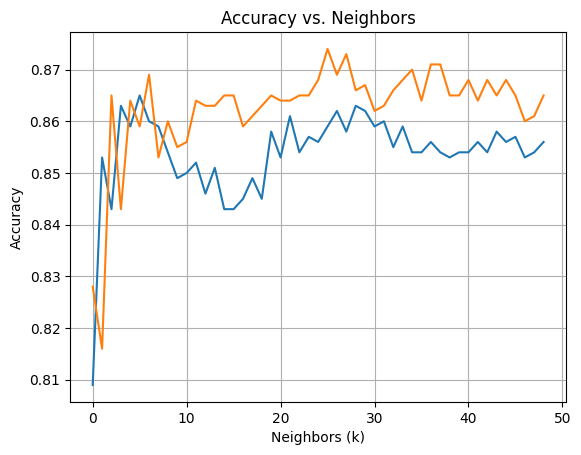

In [22]:
plt.plot(my_accuracies_test, label="My test")
plt.plot(lib_accuracies_test, label="Lib test")
plt.xlabel('Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Neighbors')
plt.grid(True)
plt.show()

# Lowess

$$
w_i = K(y(x_i) - a_{kNN}(x_i, D_{train} - \{x_i\}))
$$

In [23]:
def dist(y1, y2):
  if y1 == y2:
    return 1
  return 0
def kernel(x):
  if x == 1:
    return 1
  return 0
def my_lowess(X, y, kernel=kernel):
  w = []
  for i in range(len(X)):
    new_X = np.delete(X, i, axis=0)
    new_y = np.delete(y, i, axis=0)
    w.append(kernel(dist(y[i], knn_classifier(X[i], new_X, new_y))))
    
  return w 

def lib_lowess(X, y, kernel=kernel):
  w = []
  for i in range(len(X)):
    new_X = np.delete(X, i, axis=0)
    new_y = np.delete(y, i, axis=0)
    knn = KNeighborsClassifier()
    knn.fit(new_X, new_y)  
    y_pred = knn.predict(np.array([X[i]]))[0]
    w.append(kernel(dist(y[i], y_pred)))
    
  return w 

In [24]:
def calculate_accuracy(x_test, y_test, x_train, y_train, weights=None):
    y_pred = []
    for u in x_test:
        y_pred.append(knn_classifier(u, x_train, y_train, aprior_weights=weights))
    return accuracy_score(y_test, y_pred)

print("My classifier without lowess:", calculate_accuracy(X_test, y_test, X_train, y_train))
print("My classifier with lowess:", calculate_accuracy(X_test, y_test, X_train, y_train, my_lowess(X_train, y_train)))

My classifier without lowess: 0.828
My classifier with lowess: 0.838


Сэмплирование

In [25]:
prior_weights=lib_lowess(X_train, y_train)

sampled_X_train = []
sampled_y_train = []
for i in range(len(X_train)):
    if prior_weights[i] == 1:
        sampled_X_train.append(X_train[i])
        sampled_y_train.append(y_train[i])
        
sampled_X_train = np.array(sampled_X_train)
sampled_y_train = np.array(sampled_y_train)
print(sampled_X_train.shape, X_train.shape)

(2791, 40) (3200, 40)


In [26]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(sampled_X_train, sampled_y_train)

print("Lib classifier without lowess:", knn.score(X_test, y_test))

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

print("Lib classifier with lowess:", knn.score(X_test, y_test))

Lib classifier without lowess: 0.846
Lib classifier with lowess: 0.857
